In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

/home/mohsin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
training_data = pickle.load(open("../datasets/cifar10/training_data.pickle",'rb'))

In [3]:
test_data = pickle.load(open("../datasets/cifar10/test_data.pickle",'rb'))

### Defining the auto-encoder

In [4]:
autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    
    # Conv1
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding='same'),

    # Conv2 #
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding='same'),

    # Conv 3 #
    tf.keras.layers.Conv2D(filters = 64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding='same'),
    
    tf.keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same', name='bottleneck'),
    tf.keras.layers.UpSampling2D((2, 2)),
    
    # DeConv2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),

    # Deconv3
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'),
])
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Preparing the dataset.

In [5]:
x_train = np.array(training_data['features'])
x_train = x_train / 255.0 # scaling

x_test = np.array(test_data['features'])
x_test = x_test / 255.0

In [6]:
x_test.shape

(10000, 32, 32, 3)

In [7]:
trained_model = autoencoder.fit(x_train, x_train, batch_size=32, epochs=15, verbose=1, validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 82s 2ms/sample - loss: 0.0137 - val_loss: 0.0101
Epoch 2/15
50000/50000 [==============================] - 84s 2ms/sample - loss: 0.0095 - val_loss: 0.0091
Epoch 3/15
50000/50000 [==============================] - 77s 2ms/sample - loss: 0.0084 - val_loss: 0.0081
Epoch 4/15
50000/50000 [==============================] - 73s 1ms/sample - loss: 0.0078 - val_loss: 0.0075
Epoch 5/15
50000/50000 [==============================] - 75s 1ms/sample - loss: 0.0073 - val_loss: 0.0072
Epoch 6/15
50000/50000 [==============================] - 72s 1ms/sample - loss: 0.0070 - val_loss: 0.0068
Epoch 7/15
50000/50000 [==============================] - 74s 1ms/sample - loss: 0.0068 - val_loss: 0.0071
Epoch 8/15
50000/50000 [==============================] - 74s 1ms/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 9/15
50000/50000 [==============================] - 75s 1ms/sample - loss: 0.0065 - val_

In [8]:
encoder = tf.keras.Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

## Generating the gensim index

### Preparing data for gensim indices

In [9]:
training_encodings = encoder.predict(x_train)
test_encodings = encoder.predict(x_test)

In [10]:
training_encodings = [x.ravel() for x in training_encodings]
test_encodings =  [x.ravel() for x in test_encodings]

In [11]:
indices = []
for item in training_encodings:
    indices.append([(x,y) for (x,y) in enumerate(list(item))])
    
for item in test_encodings:
    indices.append([(x,y) for (x,y) in enumerate(list(item))])

### Generating index

In [12]:
test_encodings[0].shape

(160,)

In [13]:
index = gensim.similarities.Similarity("index",indices,160)

## Testing

In [15]:
data_dictionary = dict()
data_dictionary['label'] = training_data['label'] + test_data['label']
data_dictionary['features'] = training_data['features'] + test_data['features']

In [19]:
index.num_best = 25
predict_item = 0 #3 #863
index[encoder.predict(x_train[predict_item].reshape(1,32,32,3)).ravel()][:3]

[(0, 1.0), (57408, 0.9774195551872253), (4637, 0.9766730070114136)]

In [20]:
similar_classes = dict()
similar_classes['Label'] = []
similar_classes['Features'] = []
for i in [x[0] for x in index[encoder.predict(x_train[predict_item].reshape(1,32,32,3)).ravel()]]:
    similar_classes['Label'].append(data_dictionary['label'][i])
    similar_classes['Features'].append(data_dictionary['features'][i])

In [21]:
def plot_images(data_dictionary):
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.title('Class = '+str(data_dictionary['Label'][i]))
        plt.imshow(data_dictionary['Features'][i])

Original Class is [6]


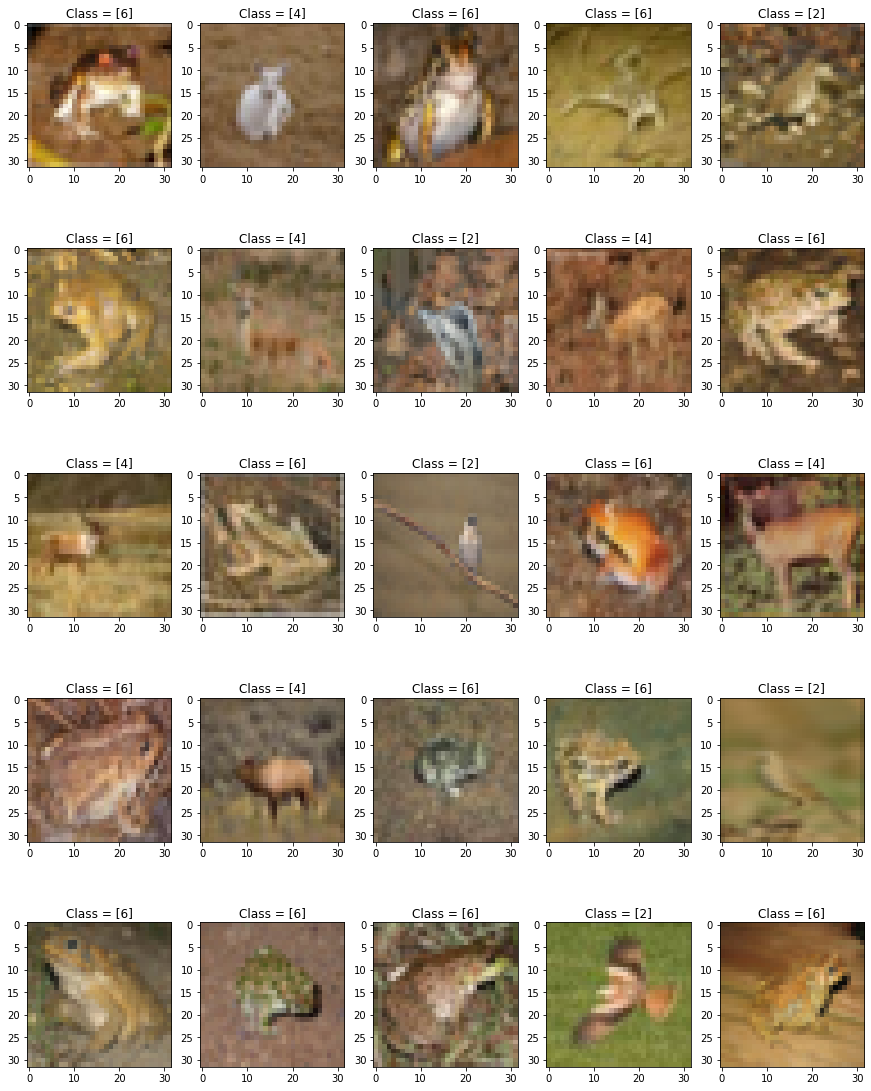

In [22]:
print (f"Original Class is {data_dictionary['label'][predict_item]}")
plt.figure(figsize=(15,20))
plot_images(similar_classes)
plt.show()

### Comments
It has confused class 6 with class 4 and 2 which are pretty much different to class 6. Our task is to find the visually similar objects and not by the classes the images are so small that sometimes it is hard to understand teh object by event humna beings.

The results may improve by changing the similarity measure, currently we are using the cosine similarity. Also we can increase the embedding size from 15 to 25 or something higher which will further improve the results.